### 1)Extraction des données 

In [1]:
import os
from os import listdir, path
import tarfile
import random
import numpy as np
import keras
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#attention au path bien avoir une hierarchie : data -> Dossier suivant dans data : data_test.tar.gz ,data_train.tar.gz, data_train.csv 
if not path.exists('data/data_test/'):
    print('Extracting test image files...')
    tar = tarfile.open("./data/data_test.tar.gz", "r:gz")
    tar.extractall('data/')
if not path.exists('data/data_train/'):
    print('Extracting train image files...')
    tar = tarfile.open("./data/data_train.tar.gz", "r:gz")
    tar.extractall('data/')

### Display utility functions

In [3]:
def show(image):
    plt.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
    plt.title("image shape: "+ str(image.shape), fontsize=14)
    plt.axis('off');
    
def show_multiple(images, figsize):
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for col, image in zip(ax, images):
        col.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
        col.set_title("image shape: "+ str(image.shape), fontsize=14)
    plt.tight_layout()
    plt.axis('off');

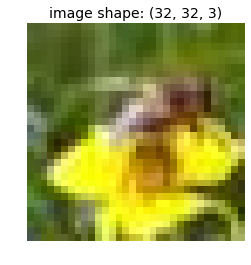

In [4]:
sample_image = imread("./data/data_train/10.jpg")
show(sample_image)

### Importer les Images (Train and Test) et les trier afin qu'elles soient en adéquation avec le fichier CSV

In [5]:
import pandas as pd

def load_data(data_path):
    csv_path = os.path.join(data_path, "labels_train.csv")
    return pd.read_csv(csv_path) # note the returned variable

In [6]:
def conv(v):
    v2 = [s.strip('.jpg') for s in v] # remove the .jpg from the string borders 
    v2 = list(map(int, v2))
    return v2

In [7]:
def int_to_imagepath (v):
    v1 = list(map(str, v))
    #print (v1)
    v1 = [s.replace(s,s+".jpg") for s in v1] 
    return v1

    Id    Category
0    0      rabbit
1    1  chimpanzee
2    2    kangaroo
3    3        bear
4    4      rabbit
5    5    kangaroo
6    6     dolphin
7    7         fox
8    8        wolf
9    9         bee
10  10         bee
y lenght :  7200
X lenght :  7200


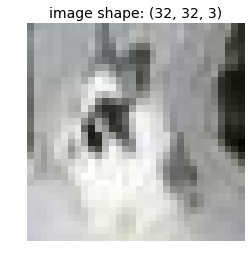

In [8]:
GLOBAL_DATA_PATH = "./data"

X_train = []
files = []
files = listdir(path.join(GLOBAL_DATA_PATH, "data_train"))
files.remove('.ipynb_checkpoints') #Permet de vérifier qu'il n'ai pas d'élément avec ".ipynb_checkpoints"
files2 = conv(files) # convertion string to int
files3 = sorted(files2) # classement ordre croissant
files4 = int_to_imagepath (files3) #converte the sort list to a sort list with ".jpg"

for file in files4:
    img = load_img(path.join(GLOBAL_DATA_PATH, "data_train", file))
    X_train.append(img_to_array(img))

y_train = load_data(GLOBAL_DATA_PATH) #Pemet de charger les données du CSV

show(X_train[0])

print(y_train.head(11))
print("y lenght : ",len(y_train))
print("X lenght : ",len(X_train))

In [9]:
X_test = []
files = []
files = listdir(path.join(GLOBAL_DATA_PATH, "data_test"))

for file in files:
    img = load_img(path.join(GLOBAL_DATA_PATH, "data_train", file))
    X_test.append(img_to_array(img))

print("X_test lenght : ",len(X_test))

X_test lenght :  1800


### MODEL : VIA RESNET 50 

In [10]:
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
from skimage.transform import resize
from skimage.io import imread

In [11]:
 #Basic Implementation of resnet model
model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
model_ResNet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

c:\users\lucas\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


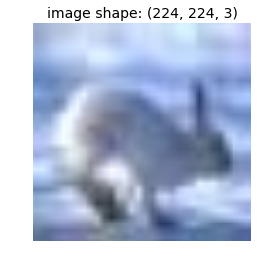

In [12]:
#We will resized the unique image to resnet image 
resnet_input_size = (224,224)
img = X_train[4]
img_resized = resize(img, resnet_input_size, mode='reflect', preserve_range=True)
show(img_resized)

In [13]:
#Print prediction of the unique image 
x = image.img_to_array(img_resized)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model_ResNet50.predict(x)
        
decoded_predictions = decode_predictions(preds)

if decoded_predictions:
    for _, name, score in decoded_predictions[0]:
        print(name, score)

dugong 0.42768285
fox_squirrel 0.17079805
grey_whale 0.14094381
Arctic_fox 0.115817636
ice_bear 0.030071782


### B) Build a headless model and compute representations of images

In [14]:
#number of layer
print(len(model_ResNet50.layers))

177


In [15]:
#Create a truncated Model using ResNet50.input and the before last layer
from keras.layers import Input, Flatten

feat_extractor_model = ResNet50(include_top=True, weights='imagenet')
feat_extractor_model.layers.pop() #remove the last dense classification layer

feat_extractor_model.summary();

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

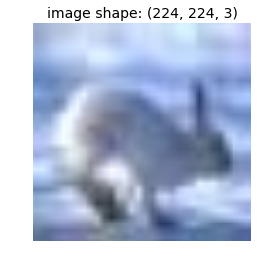

In [16]:
#resized a unique image with the resnet shape
resnet_input_size = (224,224)
img = X_train[4]
img_resized = resize(img, resnet_input_size, mode='reflect', preserve_range=True)
show(img_resized)

In [17]:
#Preeiction for the unique image
x1 = image.img_to_array(img_resized)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)
preds = feat_extractor_model.predict(x1)
        
decoded_predictions = decode_predictions(preds)

if decoded_predictions:
    for _, name, score in decoded_predictions[0]:
        print(name, score)

dugong 0.42768285
fox_squirrel 0.17079805
grey_whale 0.14094381
Arctic_fox 0.115817636
ice_bear 0.030071782


In [18]:
#Preprocess image in order to extract the feature/concept of the image
def preprocess_resnet(x, size):
    x = resize(x, size, mode='reflect', preserve_range=True)
    x = np.expand_dims(x, axis=0)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

In [35]:
#Extract/Print the image concept 
img2 = X_train[4]
img_preprocessed = preprocess_resnet(img2, resnet_input_size)
if feat_extractor_model:
    img_representation = feat_extractor_model.predict(img_preprocessed)
    print("Image deep representation shape: (%d, %d)" % img_representation.shape)
    for activation in np.ravel(img_representation):
        print(activation)

Image deep representation shape: (1, 1000)
2.7870478e-06
2.8642572e-07
0.00010685543
4.29252e-05
1.844539e-05
9.017424e-05
9.4332904e-08
5.917514e-08
8.984542e-08
3.8105782e-07
2.4398946e-06
3.6425343e-09
2.2013808e-08
1.6108942e-07
1.8765375e-08
3.767723e-08
4.8367585e-08
4.322553e-07
1.6132947e-08
7.1971336e-08
2.2919423e-06
6.0060967e-07
8.687748e-07
5.703485e-07
1.6283891e-06
6.837302e-08
1.7022719e-06
1.088141e-07
1.6831741e-07
2.9226094e-06
4.836032e-07
2.6804898e-08
5.087998e-07
7.909739e-06
1.21899375e-05
2.971364e-08
3.130135e-07
3.2083094e-08
3.4995887e-07
2.6693344e-06
3.7369956e-09
4.973411e-07
9.4097635e-07
5.4148777e-06
2.6554838e-08
9.108247e-08
1.2531468e-08
2.406485e-07
3.5093643e-07
8.30594e-09
1.0493006e-08
0.0004762551
2.0334296e-08
1.7082395e-07
7.6452295e-08
2.030127e-09
2.52508e-08
9.51618e-09
4.0959915e-08
3.1869803e-07
1.0325638e-08
7.270261e-09
8.285964e-07
6.5752374e-08
2.3291442e-07
4.2111367e-07
3.2013517e-07
3.8720792e-08
1.148188e-06
1.4548387e-07
1.24826

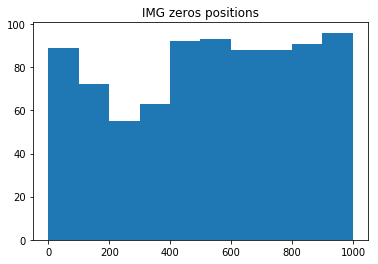

In [36]:
#Print the class of the image
if feat_extractor_model:
    plt.hist(np.where(img_representation <= 10e-6)[1]) #We consider 10e-6 = 0 for cat representation
    plt.title("IMG zeros positions")
    plt.show()

### C) Retrain a model from computed representations of images

In [ ]:
#Define classes with the variable y
classes = y_train["Category"].as_matrix() #transformer y en tableau avec les differentes classes

##### NE MARCHE PAS - A VOIR #######
#Define X_train_reshape : it x train but we have to reshaped each image inside with resnet size
X_train_resized = []   
for i in range (0,len(X_train)):  
    X_train_resized.append(resize(X_train[i], resnet_input_size, mode='reflect', preserve_range=True))

#train_test_split(np.asarray(X), np.asarray(Y), test_size=test_ratio, random_state=seed)

print("Lenght X_train",len(X_train))
print("shape X_train : ",len(X_train[0]),len(X_train[0][0]), len(X_train[0][0][0]))
print ("type", type(X_train))

print("shape X_train_resized ",len(X_train_resized))
print("shape X_train_resized: ",len(X_train_resized[0]),len(X_train_resized[0][0]), len(X_train_resized[0][0][0]))
print ("type", type(X_train_resized))

c:\users\lucas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [38]:
preprocess_input(X_train)

TypeError: list indices must be integers or slices, not tuple

In [23]:
if feat_extractor_model:
    X_extracted_tr = feat_extractor_model.predict(preprocess_input(X_train), verbose=1)
    
    #X_extracted_val = feat_extractor_model.predict(preprocess_input(X_val), verbose=1)
    print('Done extracting resnet50 features..')

TypeError: list indices must be integers or slices, not tuple